In [24]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import collections
import pickle
import gc

import pymc3 as pm
import arviz as az

In [4]:
%matplotlib inline
from warnings import filterwarnings
filterwarnings("ignore")
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
os.environ['THEANO_FLAGS'] = 'device=cpu'

import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(12345)
rc = {'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20, 'font.size': 20,
      'legend.fontsize': 12.0, 'axes.titlesize': 10, "figure.figsize": [12, 6]}
sns.set(rc = rc)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
import pmlearn
from pmlearn.naive_bayes import GaussianNB
print('Running on pymc-learn v{}'.format(pmlearn.__version__))

Running on pymc-learn v0.0.1.rc3


In [6]:
df_nostr = pd.read_csv('yt_allcountry_trend5days_nostr.csv', index_col=None)

In [7]:
X = df_nostr.drop(['trend_over_5_days'],axis=1)
y = df_nostr['trend_over_5_days']

In [8]:
X

,views,likes,dislikes,comment_count
0,17158579,787425,43420,125882
1,1014651,127794,1688,13030
2,3191434,146035,5339,8181
3,2095828,132239,1989,17518
4,33523622,1634130,21082,85067
...,...,...,...,...
178694,279728,19691,135,579
178695,1549110,21905,1516,1318
178696,2183462,79677,2034,3464
178697,607422,26166,895,3517


In [9]:
y

0         1
1         0
2         1
3         1
4         1
         ..
178694    0
178695    0
178696    0
178697    0
178698    0
Name: trend_over_5_days, Length: 178699, dtype: int64

In [10]:
X_10k = X[:10000]
X_50k = X[:50000]
X_100k = X[:100000]

y_10k = y[:10000]
y_50k = y[:50000]
y_100k = y[:100000]

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train_10k, X_test_10k, y_train_10k, y_test_10k = train_test_split(X_10k, y_10k, test_size=0.25, random_state=42)
X_train_50k, X_test_50k, y_train_50k, y_test_50k = train_test_split(X_50k, y_50k, test_size=0.25, random_state=42)
X_train_100k, X_test_100k, y_train_100k, y_test_100k = train_test_split(X_100k, y_100k, test_size=0.25, random_state=42)

### Custom Model described in Generative / Graphical Model

### Implemented with pymc3

In [2]:
import pymc3 as pm

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.1


In [17]:
n = len(X_train_10k)
# n = len(X_train)

In [18]:
with pm.Model() as naive_bayes_5days:

    # Prior Beta
    pi = pm.Beta("pi", 0.5, 0.5)
    
    # Prior - lambda class0 and class 1
    lambda0 = pm.Gamma(f"lambda_{i}", 10, 10)
    lambda1 = pm.Gamma(f"lambda_{i}", 1, 0.5)
    
    for i in range(n):
        # latent variable
        y_i = pm.Bernoulli(f"y_{i}", p=pi)
        
        # if y_i is class0 then use lambda0, else use lambda1 ??
        
        # observed variable, for each metric 
        for j in range(4):
            x_i = pm.Poisson(f"x_{i}_{j}", mu=lambda0)
    trace = pm.sample(n)

KeyboardInterrupt: 

In [20]:
with pm.Model() as naive_bayes_5days:

    # Prior Beta
    pi = pm.Beta("pi", 0.5, 0.5)
    y_i = pm.Bernoulli(f"y", p=pi)
    
    
    # Prior - lambda class0 and class 1
    lambda0 = pm.Gamma(f"lambda", 10, 10)
#     lambda1 = pm.Gamma(f"lambda_{i}", 1, 0.5)
    
    x_i = pm.Poisson(f"x", mu=lambda0)
    trace = pm.sample(n)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_10025, pi]
>BinaryGibbsMetropolis: [y_10025]
>Metropolis: [x_10025_1]


Sampling 4 chains for 1_000 tune and 134_024 draw iterations (4_000 + 536_096 draws total) took 159 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'y_10025'}>,
        <AxesSubplot:title={'center':'y_10025'}>],
       [<AxesSubplot:title={'center':'x_10025_1'}>,
        <AxesSubplot:title={'center':'x_10025_1'}>],
       [<AxesSubplot:title={'center':'pi'}>,
        <AxesSubplot:title={'center':'pi'}>],
       [<AxesSubplot:title={'center':'lambda_10025'}>,
        <AxesSubplot:title={'center':'lambda_10025'}>]], dtype=object)

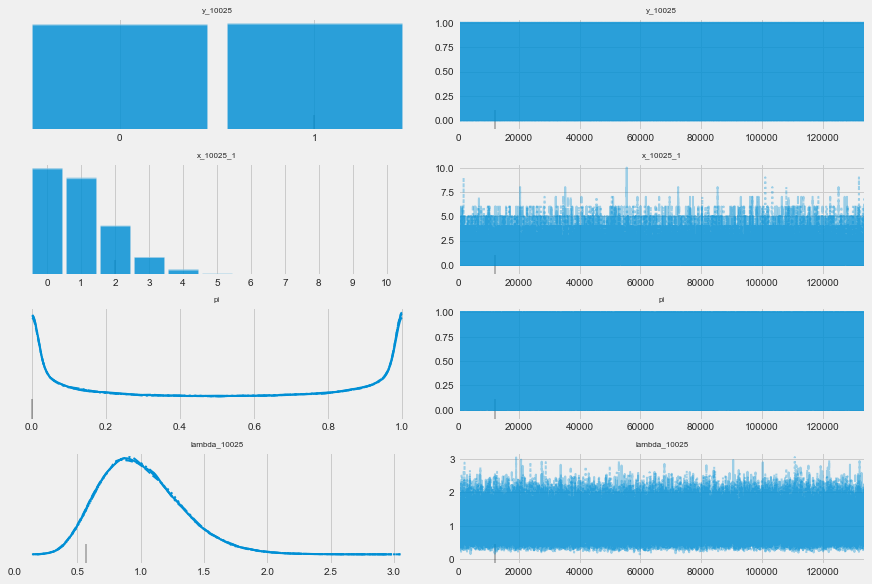

In [25]:
with naive_bayes_5days:
    az.plot_trace(trace);

In [26]:
with naive_bayes_5days:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y_10025,0.50,0.50,0.00,1.0,0.0,0.0,185286.91,185286.91,1.0
x_10025_1,1.01,1.05,0.00,3.0,0.0,0.0,81785.99,98797.55,1.0
pi,0.50,0.35,0.01,1.0,0.0,0.0,147336.05,236278.50,1.0
lambda_10025,1.00,0.32,0.43,1.6,0.0,0.0,224960.83,247659.21,1.0


### Adding observed=y_10k in y_i Bern()

In [ ]:
n = len(X_10k)a
# n = len(X_train)

In [29]:
with pm.Model() as naive_bayes_5days:

    # Prior Beta
    pi = pm.Beta("pi", 0.5, 0.5)
    y_i = pm.Bernoulli("y", p=pi, observed=y_10k)
    
    # Prior - lambda class0 and class 1
    lambda0 = pm.Gamma("lambda", 10, 10)
#     lambda1 = pm.Gamma(f"lambda_{i}", 1, 0.5)
    
#     lambda1 = lambda0 * y_i
    
    x_i = pm.Poisson("x", mu=lambda0)
    trace = pm.sample(n)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda, pi]
>Metropolis: [x]


Sampling 4 chains for 1_000 tune and 134_024 draw iterations (4_000 + 536_096 draws total) took 151 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [32]:
x_0 = X_10k['views'].values
x_c = x_0 - x_0.mean()

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>],
       [<AxesSubplot:title={'center':'pi'}>,
        <AxesSubplot:title={'center':'pi'}>],
       [<AxesSubplot:title={'center':'lambda'}>,
        <AxesSubplot:title={'center':'lambda'}>]], dtype=object)

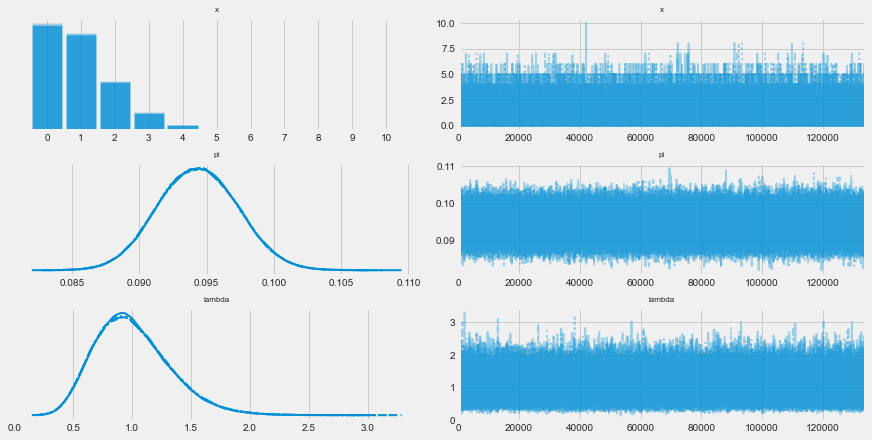

In [30]:
with naive_bayes_5days:
    az.plot_trace(trace);

In [31]:
with naive_bayes_5days:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,1.00,1.05,0.00,3.0,0.0,0.0,84239.30,95699.39,1.0
pi,0.09,0.00,0.09,0.1,0.0,0.0,431699.82,348550.61,1.0
lambda,1.00,0.32,0.44,1.6,0.0,0.0,289800.88,329727.28,1.0


[2 2 1 ... 0 0 1]


AttributeError: module 'arviz' has no attribute 'hpd'

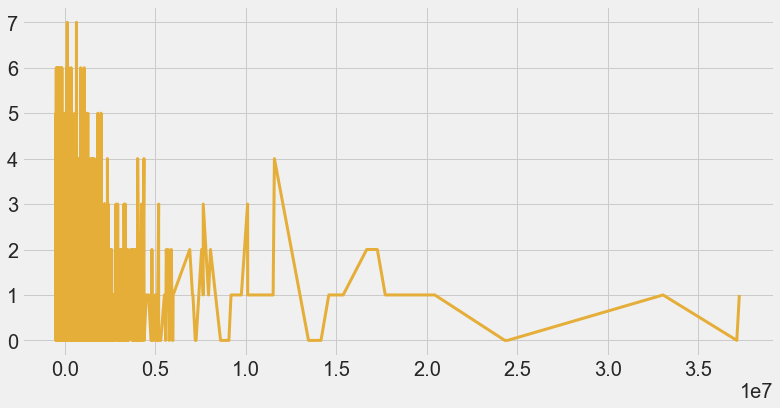

In [47]:
x = trace['x']
print(x)
idx = np.argsort(x_c)
plt.plot(x_c[idx], x[idx], color='C2', lw=3)
plt.vlines(trace['pi'].mean(), 0, 1, color='k')
pi_hpd = az.hpd(trace['pi'])
plt.fill_betweenx([0, 1], pi_hpd[0], pi_hpd[1], color='k', alpha=0.5)

plt.scatter(x_c, np.random.normal(y_simple, 0.02),
            marker='.', color=[f'C{x}' for x in y_simple])
az.plot_hpd(x_c, trace['x'], color='C2')

plt.xlabel('views')
plt.ylabel('x', rotation=0)
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1));